----
----

In [50]:
import warnings

In [51]:
warnings.filterwarnings("ignore")

In [52]:
import numpy as np

In [53]:
import torch

In [54]:
import torch.nn as nn

In [55]:
import torch.optim as optim

In [56]:
from torch.utils.data import DataLoader, TensorDataset

In [57]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [58]:
from typing import List

In [59]:
from cryptography.hazmat.primitives.asymmetric import rsa, padding

In [60]:
from cryptography.hazmat.primitives import hashes

In [61]:
import matplotlib.pyplot as plt

In [62]:
import seaborn as sns

In [63]:
import pandas as pd

In [64]:
import asyncio

In [65]:
import random

In [66]:
import hashlib

---
---

---
---

In [67]:
# Simulate MIMIC III dataset

In [68]:
def load_mimic_dataset():
    print("Loading and preprocessing MIMIC III dataset")
    n_samples = 40000
    n_features = 100
    X = np.random.randn(n_samples, n_features).astype(np.float32)
    y = np.random.randint(0, 2, n_samples).astype(np.float32)
    return X, y

In [69]:
X, y = load_mimic_dataset()

Loading and preprocessing MIMIC III dataset


In [70]:
# Convert to DataFrame for easier EDA

In [71]:
feature_names = [f"feat_{i}" for i in range(X.shape[1])]

In [72]:
df = pd.DataFrame(X, columns=feature_names)

In [73]:
df['label'] = y

---
---

---
---

In [74]:
#  Exploratory Data Analysis (EDA)


=== Exploratory Data Analysis (EDA) ===
Dataset shape: (40000, 101)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, feat_0 to label
dtypes: float32(101)
memory usage: 15.4 MB
None

Dataset head:
     feat_0    feat_1    feat_2    feat_3    feat_4    feat_5    feat_6  \
0  0.582027 -2.068376  0.089395 -0.442589  0.007728  0.945312 -0.552569   
1  0.615164  0.709411 -0.140553 -0.631241  0.599451  0.385711 -0.809890   
2 -0.361724 -0.062894 -0.447878  0.658143 -0.395284  1.592964  1.465211   
3 -0.284626 -1.972089  0.288028 -1.443925  0.444854  0.411566 -0.941403   
4  2.254038 -0.202339 -0.183245 -1.441910  0.945930  0.953176  0.789075   

     feat_7    feat_8    feat_9  ...   feat_91   feat_92   feat_93   feat_94  \
0 -1.873006  2.044482 -0.997228  ...  1.542736  0.243475 -0.404157  0.001795   
1  1.419036  0.293352  0.729819  ... -0.193610  0.744586  0.641947 -0.270268   
2 -0.891544  0.069704 -0.650657  ...  0.608267  

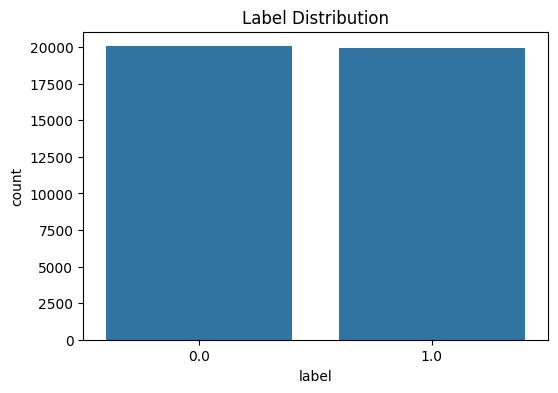

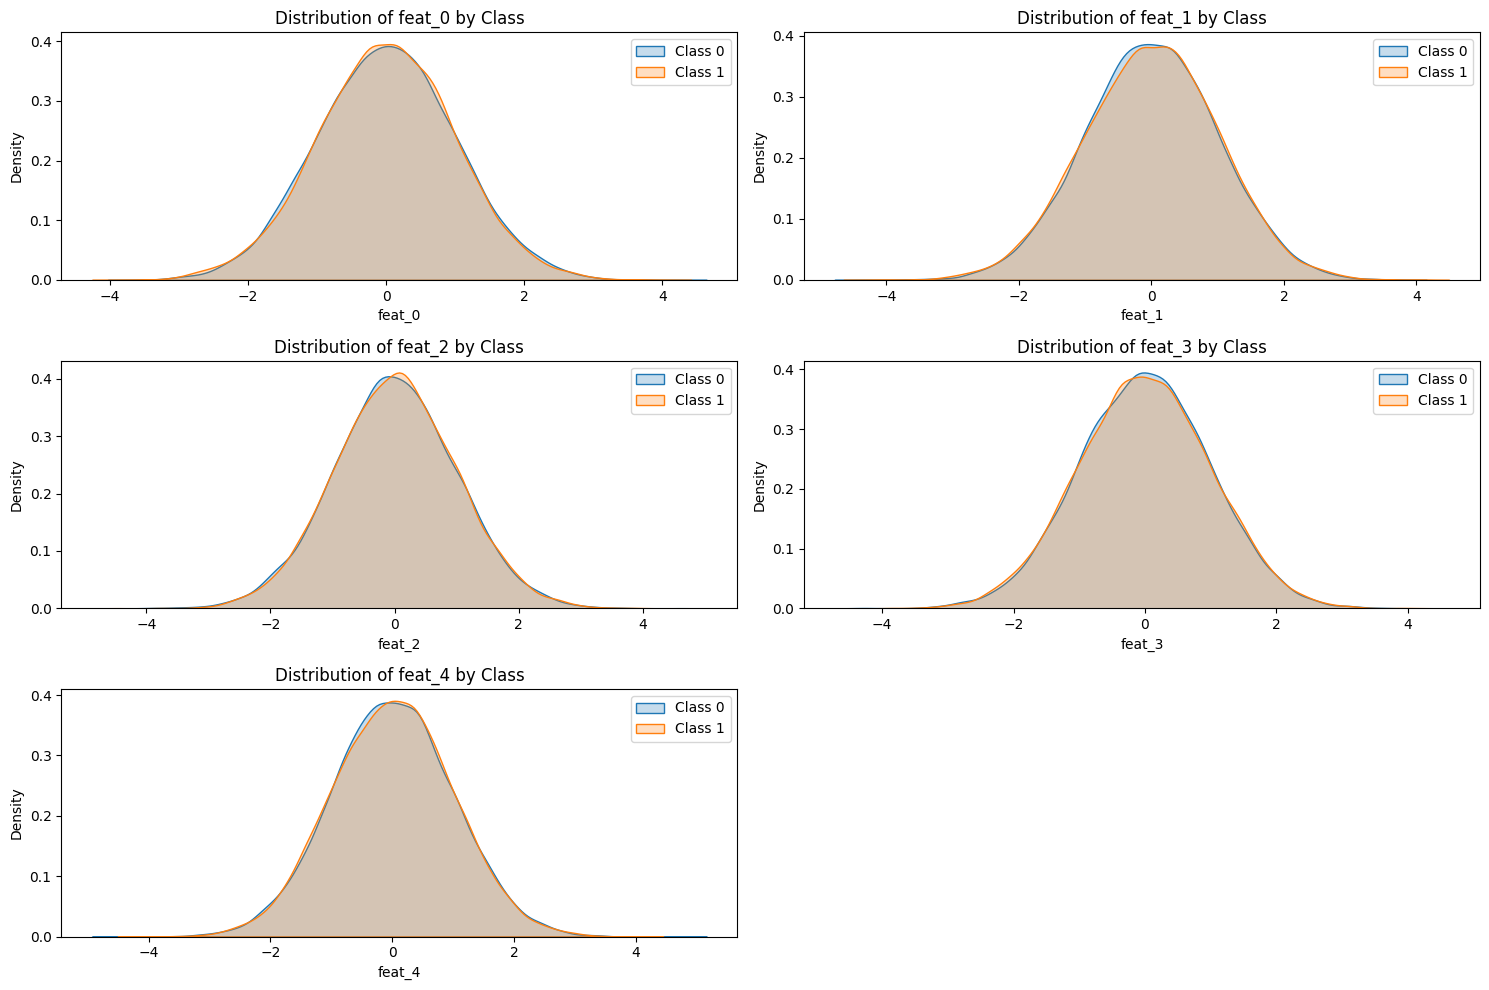

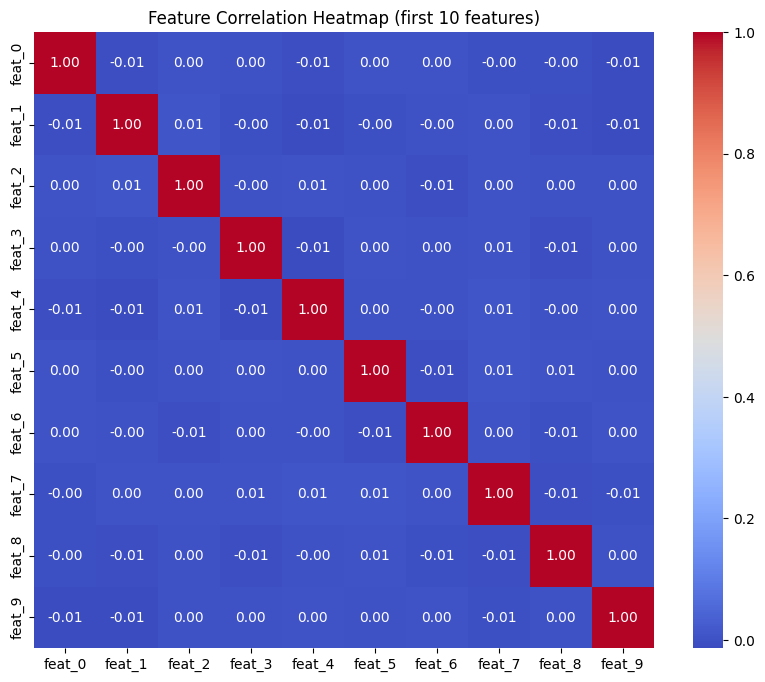

In [75]:
def perform_eda(df):
    print("\n=== Exploratory Data Analysis (EDA) ===")
    print(f"Dataset shape: {df.shape}")
    print("\nDataset info:")
    print(df.info())
    print("\nDataset head:")
    print(df.head())
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print("\nFeature summary statistics (first 5 features):")
    print(df[feature_names[:5]].describe().T)

    # Plot label distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df)
    plt.title("Label Distribution")
    plt.show()

    # KDE plots for first 5 features by class
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(3, 2, i + 1)
        sns.kdeplot(df[df['label'] == 0][feature_names[i]], label='Class 0', fill=True)
        sns.kdeplot(df[df['label'] == 1][feature_names[i]], label='Class 1', fill=True)
        plt.title(f"Distribution of {feature_names[i]} by Class")
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Correlation heatmap of first 10 features
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[feature_names[:10]].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Feature Correlation Heatmap (first 10 features)")
    plt.show()

perform_eda(df)

----
---

----
----

In [76]:
# Partition dataset to simulate multiple institutions

In [77]:
def partition_dataset(df: pd.DataFrame, n_institutions: int) -> List[pd.DataFrame]:
    print(f"\nPartitioning dataset into {n_institutions} institutions")
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    size = len(df) // n_institutions
    institution_data = []
    for i in range(n_institutions):
        start_idx = i * size
        end_idx = (i + 1) * size if i != n_institutions - 1 else len(df)
        inst_df = df_shuffled.iloc[start_idx:end_idx].copy()
        # Add institution-specific feature bias to simulate heterogeneity
        inst_df.loc[:, feature_names] += np.random.randn(*inst_df[feature_names].shape).astype(np.float32) * 0.1 * i
        institution_data.append(inst_df)
    return institution_data

In [78]:
n_institutions = 5

In [79]:
institution_data = partition_dataset(df, n_institutions)


Partitioning dataset into 5 institutions


---
---

---
---

In [80]:
# Differential Privacy: Laplacian noise addition

In [81]:
class DifferentialPrivacy:
    def __init__(self, epsilon: float, delta: float):
        self.epsilon = epsilon
        self.delta = delta

    def add_noise(self, data: np.ndarray) -> np.ndarray:
        sensitivity = 1.0
        noise_scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, noise_scale, data.shape).astype(np.float32)
        return data + noise

In [82]:
dp = DifferentialPrivacy(epsilon=0.1, delta=1e-5)

---
---

---
---

In [83]:
# Neural Network Model

In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [85]:
input_size = X.shape[1]

In [86]:
hidden_size = 64

In [87]:
output_size = 1

----
---

In [88]:
# Federated Averaging class

In [89]:
class FederatedAveraging:
    def __init__(self, model: nn.Module, n_institutions: int):
        self.model = model
        self.n_institutions = n_institutions

    def client_update(self, model: nn.Module, X: np.ndarray, y: np.ndarray, n_epochs: int) -> nn.Module:
        model.train()
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters())
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y).unsqueeze(1)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        for _ in range(n_epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return model

    def aggregate_models(self, models: List[nn.Module]) -> nn.Module:
        global_model = NeuralNetwork(input_size, hidden_size, output_size)
        global_dict = global_model.state_dict()

        for k in global_dict.keys():
            global_dict[k] = torch.stack([m.state_dict()[k] for m in models], dim=0).mean(dim=0)

        global_model.load_state_dict(global_dict)
        return global_model

In [90]:
fedavg = FederatedAveraging(NeuralNetwork(input_size, hidden_size, output_size), n_institutions)

---
---

---
---

In [91]:
# Secure Aggregation with RSA encryption simulation

In [92]:
class SecureAggregation:
    def __init__(self):
        self.private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048
        )
        self.public_key = self.private_key.public_key()

    def encrypt(self, data: bytes) -> bytes:
        chunk_size = 190
        encrypted_chunks = []
        for i in range(0, len(data), chunk_size):
            chunk = data[i:i+chunk_size]
            encrypted_chunk = self.public_key.encrypt(
                chunk,
                padding.OAEP(
                    mgf=padding.MGF1(algorithm=hashes.SHA256()),
                    algorithm=hashes.SHA256(),
                    label=None
                )
            )
            encrypted_chunks.append(encrypted_chunk)
        return b"".join(encrypted_chunks)

    def decrypt(self, encrypted_data: bytes) -> bytes:
        # Simulation placeholder: returns data as-is
        return encrypted_data

In [93]:
secure_agg = SecureAggregation()

----
---

----
----

In [94]:
# Model compression by random pruning (masking)

In [95]:
def compress_model(model: nn.Module, compression_ratio: float) -> nn.Module:
    compressed_model = NeuralNetwork(input_size, hidden_size, output_size)
    compressed_dict = compressed_model.state_dict()
    for k, v in model.state_dict().items():
        mask = (torch.rand_like(v) < compression_ratio).float()
        compressed_dict[k] = v * mask
    compressed_model.load_state_dict(compressed_dict)
    return compressed_model

---
---

---
---

In [96]:
# Federated learning process

In [97]:
def federated_learning(institution_data: List[pd.DataFrame], n_rounds: int, n_epochs: int) -> nn.Module:
    global_model = NeuralNetwork(input_size, hidden_size, output_size)

    for round_idx in range(n_rounds):
        print(f"--- Federated Learning Round {round_idx + 1} / {n_rounds} ---")
        client_models = []

        for i, inst_df in enumerate(institution_data):
            print(f"Training on Institution {i + 1} / {n_institutions} with data size {len(inst_df)}")
            client_model = NeuralNetwork(input_size, hidden_size, output_size)
            client_model.load_state_dict(global_model.state_dict())

            X_inst = inst_df[feature_names].values.astype(np.float32)
            y_inst = inst_df['label'].values.astype(np.float32)

            # Client local training
            client_model = fedavg.client_update(client_model, X_inst, y_inst, n_epochs)

            # Add differential privacy noise to model parameters
            with torch.no_grad():
                for param in client_model.parameters():
                    noisy = dp.add_noise(param.data.cpu().numpy())
                    param.data = torch.tensor(noisy, dtype=torch.float32)

            # Compress model
            compressed_client_model = compress_model(client_model, compression_ratio=0.8)

            # Simulate encryption (serialize state_dict, encrypt bytes)
            state_bytes = b"".join([v.cpu().numpy().tobytes() for v in compressed_client_model.state_dict().values()])
            encrypted_state = secure_agg.encrypt(state_bytes)

            # Simulate decryption
            decrypted_state = secure_agg.decrypt(encrypted_state)

            # For demo, skip actual decryption and just add compressed_client_model
            client_models.append(compressed_client_model)

        # Aggregate models
        global_model = fedavg.aggregate_models(client_models)

    return global_model


In [98]:
n_rounds = 3

In [99]:
n_epochs = 2

In [100]:
final_model = federated_learning(institution_data, n_rounds, n_epochs)

--- Federated Learning Round 1 / 3 ---
Training on Institution 1 / 5 with data size 8000
Training on Institution 2 / 5 with data size 8000
Training on Institution 3 / 5 with data size 8000
Training on Institution 4 / 5 with data size 8000
Training on Institution 5 / 5 with data size 8000
--- Federated Learning Round 2 / 3 ---
Training on Institution 1 / 5 with data size 8000
Training on Institution 2 / 5 with data size 8000
Training on Institution 3 / 5 with data size 8000
Training on Institution 4 / 5 with data size 8000
Training on Institution 5 / 5 with data size 8000
--- Federated Learning Round 3 / 3 ---
Training on Institution 1 / 5 with data size 8000
Training on Institution 2 / 5 with data size 8000
Training on Institution 3 / 5 with data size 8000
Training on Institution 4 / 5 with data size 8000
Training on Institution 5 / 5 with data size 8000


---
---

---
---

In [101]:
# Evaluate the final model on combined test data

In [102]:
def evaluate_model(model: nn.Module, df: pd.DataFrame):
    model.eval()
    X_eval = torch.from_numpy(df[feature_names].values.astype(np.float32))
    y_eval = df['label'].values.astype(np.float32)

    with torch.no_grad():
        outputs = model(X_eval).squeeze().numpy()

    preds = (outputs > 0.5).astype(int)

    acc = accuracy_score(y_eval, preds)
    auc = roc_auc_score(y_eval, outputs)

    print(f"\nFinal model accuracy: {acc:.4f}")
    print(f"Final model AUC: {auc:.4f}")

In [103]:
evaluate_model(final_model, df)


Final model accuracy: 0.5044
Final model AUC: 0.5053


---
---

---
---

In [104]:
# Save the final model

In [105]:
model_path = "federated_model.pth"

In [106]:
torch.save(final_model.state_dict(), model_path)

In [107]:
print(f"\nModel saved successfully to {model_path}")


Model saved successfully to federated_model.pth


---
---

---
---

In [108]:
# Take aways

In [109]:
"""
Asynchronous Federated Learning with Personalization in PyTorch

- Defines a simple neural network model for binary classification
- Simulates multiple clients training locally with asynchronous updates
- Aggregates client models using FedAvg algorithm
- Personalizes the global model per client with fine-tuning
- Evaluates and compares global vs personalized model accuracy per client
- Fully runnable in Jupyter/Colab using asyncio without blocking the event loop
"""


'\nAsynchronous Federated Learning with Personalization in PyTorch\n\n- Defines a simple neural network model for binary classification\n- Simulates multiple clients training locally with asynchronous updates\n- Aggregates client models using FedAvg algorithm\n- Personalizes the global model per client with fine-tuning\n- Evaluates and compares global vs personalized model accuracy per client\n- Fully runnable in Jupyter/Colab using asyncio without blocking the event loop\n'

In [110]:
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F

In [111]:
import numpy as np, random, asyncio, time

In [112]:
class SimpleGlobalModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, output_size=1):
        super(SimpleGlobalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [113]:
async def async_client_update(model, data, epochs=1):
    await asyncio.sleep(random.uniform(0, 0.05))
    X, y = data
    local_model = SimpleGlobalModel(input_size=X.shape[1])
    local_model.load_state_dict(model.state_dict())
    optimizer = optim.Adam(local_model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)
    local_model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = local_model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
    return local_model.state_dict()

In [114]:
def average_weights(w_list):
    return {k: sum(w[k] for w in w_list) / len(w_list) for k in w_list[0]}

In [115]:
async def async_federated_learning(clients_data, n_rounds=2, n_epochs=1):
    input_size = clients_data[0][0].shape[1]
    global_model = SimpleGlobalModel(input_size)
    for rnd in range(n_rounds):
        print(f"\n--- Round {rnd + 1} ---")
        tasks = [async_client_update(global_model, data, n_epochs) for data in clients_data]
        results = await asyncio.gather(*tasks)
        avg_weights = average_weights(results)
        global_model.load_state_dict(avg_weights)
    return global_model

In [116]:
def personalize_model(global_model, data, epochs=1):
    X, y = data
    model = SimpleGlobalModel(input_size=X.shape[1])
    model.load_state_dict(global_model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
    return model

In [117]:
def generate_final_report(global_model, client_models, client_data):
    global_model.eval()
    print("\n--- Final Report ---")
    for idx, (client_model, (X, y)) in enumerate(zip(client_models, client_data)):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
        with torch.no_grad():
            global_pred = global_model(X_tensor).round()
            personalized_pred = client_model(X_tensor).round()
        global_acc = (global_pred == y_tensor).float().mean().item()
        personalized_acc = (personalized_pred == y_tensor).float().mean().item()
        print(f"Client {idx + 1}: Global Acc = {global_acc:.4f}, Personalized Acc = {personalized_acc:.4f}")


----

----

In [118]:
# Run block (Notebook-safe version)

In [119]:
async def run_async_federated():
    n_clients = 3
    n_features = 10
    samples_per_client = 100
    clients_data = [(np.random.rand(samples_per_client, n_features), np.random.randint(0, 2, samples_per_client)) for _ in range(n_clients)]
    start = time.time()
    global_model = await async_federated_learning(clients_data, n_rounds=2, n_epochs=1)
    personalized_models = [personalize_model(global_model, data, epochs=1) for data in clients_data]
    generate_final_report(global_model, personalized_models, clients_data)
    print(f"\nTotal Runtime: {time.time() - start:.2f} seconds")#

In [120]:
await run_async_federated()  # Works in Colab / Jupyter


--- Round 1 ---

--- Round 2 ---

--- Final Report ---
Client 1: Global Acc = 0.5000, Personalized Acc = 0.4900
Client 2: Global Acc = 0.4700, Personalized Acc = 0.5200
Client 3: Global Acc = 0.5700, Personalized Acc = 0.5800

Total Runtime: 0.13 seconds


---
---